In [19]:
import numpy as np
import pandas as pd
from collections import defaultdict
from gensim.models import KeyedVectors
from k_means_constrained import KMeansConstrained
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Use the pre-trained Google News corpus (3 billion running words) word vector model

Estimated Time: 10 seconds

In [20]:
def create_word2vec_model():
    word2vec_path = 'GoogleNews-vectors-negative300.bin' # 3 GB file (not included in repo)
    w2v_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
    return w2v_model

Create a list of connections games from the connections.csv

In [21]:
def create_connections_games():
    df = pd.read_csv('connections.csv', names=['word0', 'word1', 'word2', 'word3', 'clue'], keep_default_na=False).iloc[1:]
    df = df[['word0', 'word1', 'word2', 'word3']]
    words_list = df.stack().tolist()
    words_list = [s.lower() for s in words_list]
    games = [words_list[i:i+16] for i in range(0, len(words_list), 16)]
    return games


Create word embeddings from pre-trained word2vec model

In [22]:
def create_w2v_embeddings(w2v_model, games):
    embeddings = []
    for i, word_set in enumerate(games):
        embeddings.append([])
        for word in word_set:
            if word in w2v_model:
                embeddings[i].append(w2v_model[word])
            else:
                embeddings[i].append([0 for _ in range(300)])

    np_embeddings = []
    for word_set in embeddings:
        np_embeddings.append(np.array(word_set))
    
    return np_embeddings

Performs K means constrianed clustering for one game (Required size 4 for clusters)

In [23]:
def kmeans_clustering(X, game, visualize=False, reduction='pca'):
    kmeans_cluster = KMeansConstrained(n_clusters=4, size_min=4, size_max=4)
    cluster_labels = kmeans_cluster.fit_predict(X)
    sil_score = silhouette_score(X, cluster_labels)

    clusters = {}
    for i, word in enumerate(game):
        cluster_label = cluster_labels[i]
        if cluster_label not in clusters:
            clusters[cluster_label] = []
        clusters[cluster_label].append(word)
    clusters = dict(sorted(clusters.items()))

    if visualize:
        visualize_clusters(X, game, cluster_labels, reduction)

    return clusters, sil_score 

Plays all the Connections games and performs K-means constrained clustering on each Connections game

In [24]:
def play_connections(connections_games, word_embeddings, metrics):
    game_results = []
    for i, game in enumerate(connections_games):
        clusters, sil_score = kmeans_clustering(word_embeddings[i], game)
        game_results.append(clusters)
        metrics["silhouette_score"].append(sil_score)
    return game_results, metrics

Evaluate results of playing all the Connections game

In [25]:
def evaluate_connections(connections_games, results, metrics):
    for i, game in enumerate(connections_games):
        result = results[i]
        
        true_list = [set() for _ in range(len(game) // 4)]
        for i, item in enumerate(game):
            true_list[i // 4].add(item)
        
        pred_list = [set(value) for value in result.values()]

        match_set_count = 0
        for true_set in true_list:
            if true_set in pred_list:
                match_set_count += 1
        
        metrics["correct_groups"].append(match_set_count)
        
    return metrics 

Visualize the clusters created by one Connections game through dimensionality reduction

Option of PCA or T-SNE

In [26]:
def visualize_clusters(X, game, cluster_labels, reduction):
    if reduction == 'pca':
        pca = PCA(n_components=2)
        X_reduced = pca.fit_transform(X)
        plt.title('Kmeans Clustering on Word2Vec - PCA Visualization')
    else:
        tsne = TSNE(perplexity=3)
        X_reduced = tsne.fit_transform(X)
        plt.title('Kmeans Clustering on Word2Vec - T-SNE Visualization')

    for cluster_label in np.unique(cluster_labels):
        plt.scatter(X_reduced[cluster_labels == cluster_label, 0], X_reduced[cluster_labels == cluster_label, 1], 
        label=f'Cluster {cluster_label}', alpha=0.5)

    for i, word in enumerate(game):
        plt.annotate(word, (X_reduced[i, 0], X_reduced[i, 1]))

    plt.legend(bbox_to_anchor=(1, 1))
    plt.savefig('./visualizations/word2vec-cluster-visualization.png')

Create histogram of the correct group accuracies from all the Connections games played

In [27]:
def visualize_group_accuracy(num_correct_groups):
    labels, counts = np.unique(num_correct_groups, return_counts=True)
    frequencies = counts / counts.sum()
    percentages = frequencies * 100
    colors = ['tab:red', 'tab:orange', 'tab:blue', 'tab:green']
    rects = plt.bar([str(l) for l in labels], percentages, color = colors)
    plt.bar_label(rects, padding = 0.5, labels = [f"{p:.2f}%" for p in percentages])
    plt.title("Group Prediction Accuracy")
    plt.xlabel("Number of Groups Correctly Predicted")
    plt.ylabel("Relative Frequency (%)")
    plt.savefig('./visualizations/word2vec-group-accuracies.png')

Create histogram to visualize the silhouette scores from all the Connections games played

In [28]:
def visualize_silhouette_score(scores):
    plt.hist(scores)
    plt.title("Silhouette Score Distribution")
    plt.xlabel("Silhouette Score")
    plt.ylabel("Count")
    plt.savefig('./visualizations/word2vec-silhouette-scores.png')

In [29]:
w2v_model = create_word2vec_model()

In [30]:
connections_games = create_connections_games()

In [31]:
word_embeddings = create_w2v_embeddings(w2v_model, connections_games)

In [32]:
metrics = defaultdict(list)
results, metrics = play_connections(connections_games, word_embeddings, metrics)

In [33]:
metrics = evaluate_connections(connections_games, results, metrics)

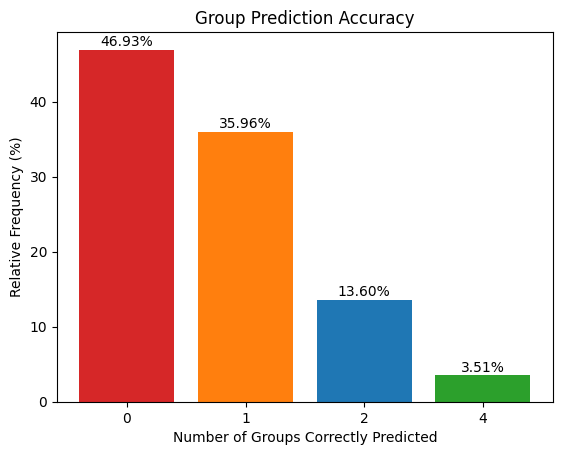

In [34]:
visualize_group_accuracy(metrics["correct_groups"])

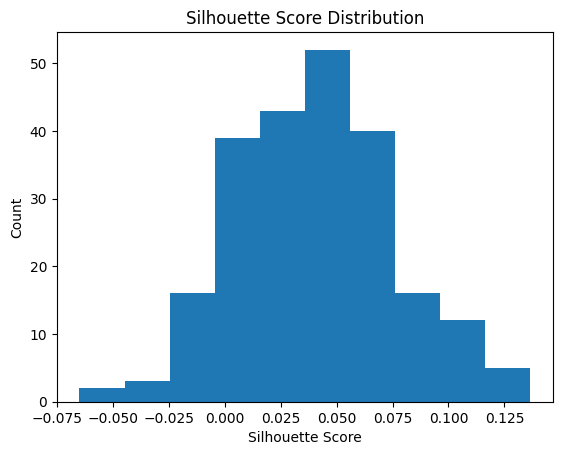

In [35]:
visualize_silhouette_score(metrics["silhouette_score"])

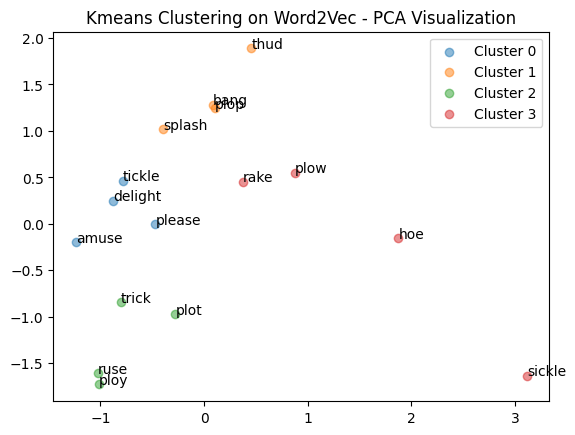

In [36]:
clusters, sil_score = kmeans_clustering(word_embeddings[40], connections_games[40], visualize=True, reduction='pca')